#**Imports**





In [28]:

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.utils as vutils

#Parameters and data prepration

In [29]:


# Batch size during training
batch_size = 64
# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 50

# Size of feature maps in generator
ngf = 32

# Size of feature maps in discriminator
ndf = 32

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
dataloader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.,), (0.5,))
                             ])),batch_size=batch_size,
                                         shuffle=True)

#weight initialization function


In [30]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

#Generator

In [31]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.Dropout2d(0.2),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d( ngf * 8, ngf*4 ,4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.Dropout2d(0.2),
            # state size. (ngf*8) x 7 x 7
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.Dropout2d(0.2),
            # state size. (ngf*4) x 14 x 14
            nn.ConvTranspose2d( ngf * 2, 1, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 28 x 28
        )

    def forward(self, input):
        return self.main(input)
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
#print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(50, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout2d(p=0.2, inplace=False)
    (4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout2d(p=0.2, inplace=False)
    (8): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout2d(p=0.2, inplace=False)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

#Checking generator output

In [32]:
fixed_noise = torch.randn(1, nz, 1, 1, device=device)
output=netG(fixed_noise)
output.shape

torch.Size([1, 1, 28, 28])

#Discriminator

In [33]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            # state size. (nc) x 28 x 28
            nn.Conv2d(nc, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 14 x 14
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 7 x 7
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 3 x 3
            nn.Conv2d(ndf * 8, 1, 3, 1,0 , bias=False),
            nn.Sigmoid()
            # state size. (1) x 1 x 1
        )

    def forward(self, input):
        return self.main(input)
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)


Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 1, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (10): Sigmoid()
  )
)


#Checking Discriminator output

In [34]:
sample=torch.randn(1,1,28,28).to(device)
netD(sample).shape

torch.Size([1, 1, 1, 1])

#Training

In [ ]:
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
      
        #  Update D network

        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        #real label with one side smoothing by 0.8
        label = torch.full((b_size,), real_label*0.8, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        lossD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        lossD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        lossD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        lossD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        lossD = lossD_real + lossD_fake
        # Update D
        optimizerD.step()

        #  Update G network
        
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        lossG = criterion(output, label)
        # Calculate gradients for G
        lossG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     lossD.item(), lossG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses 
        G_losses.append(lossG.item())
        D_losses.append(lossD.item())

Starting Training Loop...
[0/20][0/938]	Loss_D: 1.5331	Loss_G: 1.5111	D(x): 0.4911	D(G(z)): 0.5205 / 0.2531
[0/20][50/938]	Loss_D: 0.8986	Loss_G: 7.5135	D(x): 0.9170	D(G(z)): 0.2363 / 0.0008
[0/20][100/938]	Loss_D: 0.5382	Loss_G: 5.0534	D(x): 0.7395	D(G(z)): 0.0084 / 0.0074
[0/20][150/938]	Loss_D: 0.5827	Loss_G: 4.0387	D(x): 0.7280	D(G(z)): 0.0183 / 0.0268
[0/20][200/938]	Loss_D: 0.5442	Loss_G: 4.3078	D(x): 0.7973	D(G(z)): 0.0223 / 0.0171
[0/20][250/938]	Loss_D: 0.5768	Loss_G: 4.1802	D(x): 0.8044	D(G(z)): 0.0451 / 0.0220
[0/20][300/938]	Loss_D: 0.6143	Loss_G: 3.9519	D(x): 0.8507	D(G(z)): 0.0823 / 0.0224
[0/20][350/938]	Loss_D: 0.5829	Loss_G: 3.6812	D(x): 0.7714	D(G(z)): 0.0578 / 0.0292
[0/20][400/938]	Loss_D: 0.5838	Loss_G: 3.3833	D(x): 0.7513	D(G(z)): 0.0504 / 0.0426
[0/20][450/938]	Loss_D: 0.5636	Loss_G: 3.3087	D(x): 0.7517	D(G(z)): 0.0381 / 0.0420
[0/20][500/938]	Loss_D: 0.5832	Loss_G: 3.6323	D(x): 0.8150	D(G(z)): 0.0542 / 0.0304
[0/20][550/938]	Loss_D: 0.5713	Loss_G: 4.7831	D(x): 0

#Output

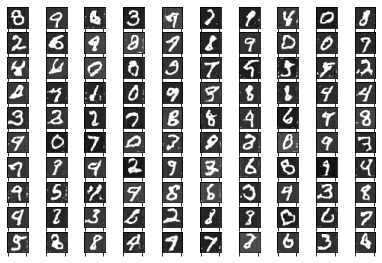

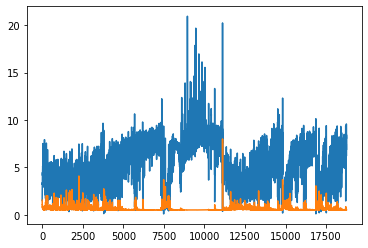

In [37]:
fig,ax=plt.subplots()
plt.tight_layout()

for i in range(1,101):
    fixed_noise = torch.randn(1, nz, 1, 1, device=device)
    #print(fixed_noise)
    output=netG(fixed_noise)
    output.shape
    image=output.cpu().detach().numpy()[0,0,:,:]
    plt.subplot(10,10,i)
    plt.tick_params(labelleft=False,left=False)
    plt.tick_params(labelbottom=False)
    plt.imshow(image,cmap="gray")
plt.show()
plt.figure()
plt.plot(G_losses)
plt.plot(D_losses)